In [1]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [279]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels
import cvxopt as cv
from cvxopt import solvers

In [2]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff

from BarraModel import barraRiskModel as brm
#from config import *

In [4]:
%matplotlib inline

In [5]:
# basic stocl pool
ZZ500Weight = 'LZ_GPA_INDEX_CSI500WEIGHT.csv'
HS300Weight = 'LZ_GPA_INDEX_HS300WEIGHT.csv'

In [6]:
filenamePrice ='LZ_GPA_DERI_AdjustedPriceForward_20.csv'

In [7]:
# Factors
# Value factor
filenamePE='LZ_GPA_VAL_PE.csv'  # 市盈率
filenamePB='LZ_GPA_VAL_PB.csv'  # 市净率
filenamePS = 'LZ_GPA_VAL_PS.csv' # 市销率
filenamePCF = 'LZ_GPA_VAL_PC.csv' # 市现率

# Growth factor
filenameYOYGR = 'LZ_GPA_FIN_IND_QFA_YOYGR.csv'  # 单季度.营业总收入同比增长率(%)
filenameYOYNETPROFIT = 'LZ_GPA_FIN_IND_QFA_YOYNETPROFIT.csv' # 单季度.归属母公司股东的净利润同比增长率(%)
filenameYOYOCF = 'LZ_GPA_FIN_IND_YOYOCF.csv' # 同比增长率-经营活动产生的现金流量净额(%)
filenameYOYROE = 'LZ_GPA_FIN_IND_YOYROE.csv' # 同比增长率-净资产收益率(摊薄)(%)
filenameYOYBPS = 'LZ_GPA_FIN_IND_YOYBPS.csv' # 相对年初增长率-每股净资产(%)

# Financial factor
filenameCAPITALIZEDTODA = 'LZ_GPA_FIN_IND_CAPITALIZEDTODA.csv'  # 资本支出/折旧和摊销
filenameCASHRATIO = 'LZ_GPA_FIN_IND_CASHRATIO.csv' # 保守速动比率
filenameCASHTOLIQDEBT = 'LZ_GPA_FIN_IND_CASHTOLIQDEBT.csv' # 货币资金／流动负债
filenameOCFTODEBT = 'LZ_GPA_FIN_IND_OCFTODEBT.csv' # 经营活动产生的现金流量净额/负债合计
filenamePROFITTOOP = 'LZ_GPA_FIN_IND_PROFITTOOP.csv' # 利润总额／营业收入

# Momentum factor
filenameTRUEMOM = 'LZ_GPA_USR_MOM.csv' # 真动量
filenameMOM1M = 'LZ_GPA_DERI_Momentum_1M.csv' # 一月反转
filenameMOM3M = 'LZ_GPA_TURNOVER_TurnoverAvg_3M.csv' # 三月反转
filenamePVO = 'LZ_GPA_DERI_PVO.csv' # 一年偏度
filenameRV1Y = 'LZ_GPA_DERI_RealizedVolatility_1Y.csv' # 一年收益波动
filenameABNORMALVOLUME = 'LZ_GPA_DERI_NormalizedAbormalVolume.csv' # 归一化异常交易量
filenameSKEW = 'LZ_GPA_DERI_TSKEW.csv'# 偏度

# Volatility factor


# Liquidity factor
filenameTURNOVER1M = 'LZ_GPA_TURNOVER_TurnoverAvg_1M.csv' # 一月换手率均值
filenameAMOUNTAVG1M = 'LZ_GPA_DERI_AmountAvg_1M.csv'      #  日均成交量
filenameILLIQ = 'LZ_GPA_DERI_ILLIQ.csv'                   # 非流动性因子
filenameVOLUME = 'LZ_GPA_QUOTE_TVOLUME.csv'               # 成交量

In [8]:
filenameFCAP = 'LZ_GPA_VAL_A_FCAP.csv'

filenameBENCH = 'LZ_GPA_INDXQUOTE_CLOSE.csv'

filenamePriceOrg = 'LZ_GPA_QUOTE_TCLOSE.csv'

In [10]:
# some useful parameters
startTime =  datetime.strptime('20120101', '%Y%m%d')
endTime = datetime.strptime('20161231', '%Y%m%d')
facNum = 5 # factor Num
path = ff.data_path # path
timeStampNum = 2500 # Number of time period
thresholdNum = 0.05  # thresholdNum to filter stocks by Nan's amount
HS300Index ='000300.SH' # HS300 index code
ZZ500Index = '000905.SH' #   ZZ500 index code

In [11]:
orgPrice = pd.read_csv(path+filenamePriceOrg,infer_datetime_format=True,parse_dates=[0],index_col=0)
orgPrice.shape

(2989, 3294)

In [12]:
stockPool = pd.read_csv(path+ZZ500Weight,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
#stockPool = stockPool.iloc[-1].dropna(how='any').index.tolist()  # get today's ZX500 stock pool
stockPool1 = pd.read_csv(path+HS300Weight,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]

In [13]:
stockPool = stockPool.dropna(how = 'all',axis =1).columns.tolist() # stock pool
stockPool1 = stockPool1.dropna(how = 'all',axis =1).columns.tolist()

In [14]:
stockPool = list((set(stockPool1)|set(stockPool)))

In [15]:
len(stockPool)

1186

In [16]:
class dataCleaning():
    
    def __init__(self,data):
        self.__data = data
    #@property
    #def _constructor(self):
    #    return dataCleaning

    #@property
    #def _constructor_sliced(self):
    #   return SubclassedSeries
        
    def narrowData(self):
        return self.__data[stockPool].loc[startTime:endTime]
    
    def Normalize(self,narrowedData):
        dataWinsorized = narrowedData.copy()
        dataWinsorizedTrans = dataWinsorized.T
        MAD = 1.483*np.abs(dataWinsorizedTrans-dataWinsorizedTrans.median(skipna=True))
        return ((dataWinsorizedTrans - dataWinsorizedTrans.mean(axis=0, skipna=True))/dataWinsorizedTrans.std(axis=0, skipna=True)).T

In [17]:
PriceDF = pd.read_csv(path+filenamePrice,infer_datetime_format=True,parse_dates=[0],index_col=0)[stockPool].loc[startTime:endTime]

In [18]:
LFCAPData = np.log10(pd.read_csv(path+filenameFCAP,infer_datetime_format=True,parse_dates=[0],index_col=0))

PBData = pd.read_csv(path+filenamePB,infer_datetime_format=True,parse_dates=[0],index_col=0)

YOYBPSData = pd.read_csv(path+filenameYOYBPS,infer_datetime_format=True,parse_dates=[0],index_col=0)

AMOUNTAVG1MData = pd.read_csv(path+filenameAMOUNTAVG1M,infer_datetime_format=True,parse_dates=[0],index_col=0)

TURNOVER1MData = pd.read_csv(path+filenameTURNOVER1M,infer_datetime_format=True,parse_dates=[0],index_col=0)

PROFITOOPData = pd.read_csv(path+filenamePROFITTOOP,infer_datetime_format=True,parse_dates=[0],index_col=0)

benchmarkData = pd.read_csv(path+filenameBENCH,infer_datetime_format=True,parse_dates=[0],index_col=0)[ZZ500Index].loc[startTime:endTime]

In [19]:
#isinstance(dataCleaning(PBData).narrowData(),dataCleaning)

In [20]:
PBData = dataCleaning(PBData).Normalize(dataCleaning(PBData).narrowData())
LFCAPData  = dataCleaning(LFCAPData ).Normalize(dataCleaning(LFCAPData ).narrowData())
YOYBPSData = dataCleaning(YOYBPSData).Normalize(dataCleaning(YOYBPSData).narrowData())
AMOUNTAVG1MData = dataCleaning(AMOUNTAVG1MData).Normalize(dataCleaning(AMOUNTAVG1MData).narrowData())
TURNOVER1MData = dataCleaning(TURNOVER1MData).Normalize(dataCleaning(TURNOVER1MData).narrowData())
PROFITOOPData = dataCleaning(PROFITOOPData).Normalize(dataCleaning(PROFITOOPData).narrowData())

In [21]:
print PBData.shape[1], LFCAPData.shape[1], YOYBPSData.shape[1], AMOUNTAVG1MData.shape[1], TURNOVER1MData.shape[1], PROFITOOPData.shape[1]

1186 1186 1186 1186 1186 1186


In [22]:
#PROFITOOPData

In [23]:
# filter and fill data
def filterAndfill(data,threshold):
    df = data.loc[:,data.isnull().sum() < data.shape[1] * threshold]
    return df.fillna(method = 'ffill').fillna(method = 'bfill')

In [24]:
PBData = PBData .loc[:, PBData .isnull().sum() < (len(PBData) * thresholdNum)]
LFCAPData  = LFCAPData .loc[:, LFCAPData .isnull().sum() < (len(LFCAPData) * thresholdNum)]
YOYBPSData = YOYBPSData .loc[:, YOYBPSData .isnull().sum() < (len(YOYBPSData) * thresholdNum)]
AMOUNTAVG1MData = AMOUNTAVG1MData .loc[:, AMOUNTAVG1MData .isnull().sum() < (len(AMOUNTAVG1MData) * thresholdNum)]
TURNOVER1MData = TURNOVER1MData .loc[:, TURNOVER1MData .isnull().sum() < (len(TURNOVER1MData) * thresholdNum)]
PROFITOOPData  = PROFITOOPData  .loc[:, PROFITOOPData .isnull().sum() < (len(PROFITOOPData ) * thresholdNum)]

PriceDF = PriceDF.loc[:, (PriceDF.isnull().sum() < (len(PriceDF) * thresholdNum))]

In [25]:
TURNOVER1MData 

,002344.SZ,000793.SZ,600059.SH,000713.SZ,600360.SH,000528.SZ,000063.SZ,601101.SH,000685.SZ,000636.SZ,...,000002.SZ,600122.SH,600469.SH,600282.SH,600739.SH,600406.SH,600866.SH,600121.SH,601908.SH,002195.SZ
LZ_GPA_TURNOVER_TurnoverAvg_1M-f,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-0.176351,-0.241920,0.050054,0.869193,-0.366411,-0.093829,-0.393634,0.019835,0.223272,-0.362456,...,-0.364535,-0.065026,-0.095687,-0.491847,-0.103122,-0.417364,-0.226168,-0.572395,1.834449,0.389762
2012-01-05,-0.148203,-0.249227,0.053181,0.922777,-0.369314,-0.073094,-0.399965,0.024752,0.273700,-0.367420,...,-0.363392,-0.064554,-0.104441,-0.497757,-0.094877,-0.417484,-0.227977,-0.583313,1.908621,0.397108
2012-01-06,-0.150965,-0.253463,0.056583,0.966051,-0.375157,-0.076563,-0.406325,0.021471,0.292534,-0.373791,...,-0.362520,-0.064029,-0.096429,-0.502588,-0.090162,-0.411667,-0.235200,-0.589101,1.945360,0.382742
2012-01-09,-0.147897,-0.271938,0.053587,0.999738,-0.383023,-0.083020,-0.407480,0.022990,0.325065,-0.376640,...,-0.365216,-0.071729,-0.099137,-0.512626,-0.072496,-0.411301,-0.236356,-0.601228,1.995226,0.356548
2012-01-10,-0.152183,-0.279319,0.037945,0.942761,-0.370101,-0.076421,-0.406706,0.089766,0.378797,-0.370965,...,-0.351053,-0.088790,-0.062426,-0.505284,-0.053147,-0.402723,-0.247932,-0.591522,1.897973,0.282578
2012-01-11,-0.168841,-0.322439,0.010055,1.036801,-0.383707,-0.020533,-0.428879,0.217896,0.474164,-0.387665,...,-0.358099,-0.089980,-0.025234,-0.534745,-0.022924,-0.417929,-0.241646,-0.626192,1.758969,0.237720
2012-01-12,-0.162372,-0.322084,-0.033919,0.959788,-0.360970,-0.013654,-0.410265,0.260215,0.470223,-0.370419,...,-0.349857,-0.099265,-0.037710,-0.505792,-0.028520,-0.400478,-0.223688,-0.592075,1.550123,0.312365
2012-01-13,-0.183801,-0.346556,-0.062592,0.961231,-0.368488,-0.000548,-0.428325,0.294343,0.510059,-0.369837,...,-0.366494,-0.093252,-0.034006,-0.528796,-0.036445,-0.414237,-0.225953,-0.616371,1.684493,0.424654
2012-01-16,-0.212042,-0.376568,-0.082489,0.984949,-0.380708,0.016878,-0.437954,0.333461,0.590162,-0.374992,...,-0.378573,-0.094583,-0.031932,-0.545493,-0.042599,-0.425377,-0.232737,-0.573792,1.777184,0.468624


In [26]:
print PBData.shape[1], LFCAPData.shape[1], YOYBPSData.shape[1] ,AMOUNTAVG1MData.shape[1], TURNOVER1MData.shape[1], PROFITOOPData.shape[1]

1078 1093 1140 1086 1086 1143


In [27]:
#len(list((DFcolumns(PBData)) & (DFcolumns(YOYBPSData))))

In [28]:
# get intersection
def getInterStk(dfList):
    '''
    To get the columns intersections of several dataframe.
    output: List, the intersection of the columns of dataframes.
    input:
    dfList: List, which contains dataframe u want to get the intersection, len(dfList) should be more than 1.
    '''
    columnsList = map(lambda x: set(x.columns.tolist()), dfList)
    stkList = reduce(lambda x,y: x & y, columnsList)
    return stkList

In [29]:
SA = getInterStk([PBData,YOYBPSData,AMOUNTAVG1MData,TURNOVER1MData,PROFITOOPData,PriceDF])

In [30]:
len(SA)

1071

In [31]:
def DFcolumns(df):
    return set(df.columns.tolist())

In [32]:
##
stkPool = list((DFcolumns(PBData)) & (DFcolumns(YOYBPSData)) & (DFcolumns(AMOUNTAVG1MData)) & (DFcolumns(TURNOVER1MData)) & (DFcolumns(PROFITOOPData))\
        & (DFcolumns(PriceDF)))
len(stkPool)

1071

In [33]:
#
def fillData(df,stkPool):
    return df[stkPool].fillna(method='ffill').fillna(method='bfill')

In [34]:
PBData = fillData(PBData,stkPool)
LFCAPData = fillData(LFCAPData,stkPool)
YOYBPSData = fillData(YOYBPSData,stkPool)
AMOUNTAVG1MData = fillData(AMOUNTAVG1MData,stkPool)
TURNOVER1MData = fillData(TURNOVER1MData,stkPool)
PROFITOOPData = fillData(PROFITOOPData,stkPool)

PriceDF = fillData(PriceDF,stkPool)

In [35]:
# independentfactor should be a list contains of dataframe
def orthoFactor(factordf, independentfactor,WLS =False, weightdf = None):
    '''
    Muti variable regression for return.
    returndf and dataframes in factorDict should have same index and same columns
    output: Dataframe, the orthogonalized result of factordf
    input: 
    factordf: Dataframe, factor to be orthogonalized
    independentfactor: List,  the values are the factor dataframe as independence in regression(all \
    with same columns and index)
    '''
    emptydf = pd.DataFrame(index = factordf.index, columns = factordf.columns, data= None, dtype =float)
    dfNum = len(independentfactor)
    if dfNum == 0:
        print 'Input is an empty list!'
        raise ValueError
    for date in factordf.index:
        factordfSlice = factordf.loc[date]
        mapfunction = map(lambda x: x.loc[date], independentfactor)
        if dfNum > 1:
            totaldf = pd.concat(mapfunction, axis=1)         
        else:
            totaldf = independentfactor[0].loc[date]
        if WLS:
            w = weightdf.loc[date]
            result = sm.WLS(factordfSlice.T,totaldf,weights = 1/w ).fit()
        else:
            result = sm.OLS(factordfSlice.T,totaldf ).fit()
        emptydf .loc[date] = result.resid
    return emptydf

In [36]:
LFCAPData.shape

(1214, 1071)

In [37]:
YOYBPSData

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
LZ_GPA_FIN_IND_YOYBPS-d,,,,,,,,,,,,,,,,,,,,,
2012-01-04,0.240171,-0.992352,-0.041829,-0.724594,-0.052970,-0.092335,-0.141171,-0.859772,-0.085465,-0.141542,...,-0.757088,0.006821,-0.172923,0.298903,-1.132173,0.492759,0.009977,-0.040529,5.103138,-0.619124
2012-01-05,0.239668,-0.992292,-0.042203,-0.724656,-0.053339,-0.092687,-0.141500,-0.859774,-0.085819,-0.141871,...,-0.757137,0.006424,-0.173237,0.298374,-1.132050,0.492141,0.009579,-0.040904,5.100416,-0.619235
2012-01-06,0.239805,-0.993245,-0.042316,-0.725372,-0.053462,-0.092844,-0.141700,-0.860609,-0.085970,-0.142071,...,-0.757881,0.006355,-0.173465,0.298562,-1.133126,0.492501,0.009513,-0.041015,5.104851,-0.619858
2012-01-09,0.240006,-0.993583,-0.042238,-0.725593,-0.053389,-0.092788,-0.141665,-0.860889,-0.085912,-0.142037,...,-0.758116,0.006454,-0.173445,0.298789,-1.133525,0.492813,0.009613,-0.040937,5.107181,-0.620033
2012-01-10,0.240006,-0.993583,-0.042238,-0.725593,-0.053389,-0.092788,-0.141665,-0.860889,-0.085912,-0.142037,...,-0.758116,0.006454,-0.173445,0.298789,-1.133525,0.492813,0.009613,-0.040937,5.107181,-0.620033
2012-01-11,0.239869,-0.994227,-0.042491,-0.726127,-0.053647,-0.093062,-0.141960,-0.861479,-0.086183,-0.142331,...,-0.758664,0.006220,-0.173752,0.298676,-1.134227,0.492779,0.009381,-0.041190,5.109043,-0.620524
2012-01-12,0.239869,-0.994227,-0.042491,-0.726127,-0.053647,-0.093062,-0.141960,-0.861479,-0.086183,-0.142331,...,-0.758664,0.006220,-0.173752,0.298676,-1.134227,0.492779,0.009381,-0.041190,5.109043,-0.620524
2012-01-13,0.239869,-0.994227,-0.042491,-0.726127,-0.053647,-0.093062,-0.141960,-0.861479,-0.086183,-0.142331,...,-0.758664,0.006220,-0.173752,0.298676,-1.134227,0.492779,0.009381,-0.041190,5.109043,-0.620524
2012-01-16,0.239794,-0.994252,-0.042555,-0.726163,-0.053709,-0.093123,-0.142019,-0.861509,-0.086245,-0.142391,...,-0.758698,0.006155,-0.173810,0.298599,-1.134246,0.492694,0.009316,-0.041253,5.108771,-0.620563


In [43]:
orthorizedDF = orthoFactor(YOYBPSData,[PROFITOOPData],True, weight)

In [44]:
orthorizedDF.head()

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
LZ_GPA_FIN_IND_YOYBPS-d,,,,,,,,,,,,,,,,,,,,,
2012-01-04,0.151757,-1.078286,-0.129363,-0.811546,-0.140540,-0.181008,-0.229801,-0.947120,-0.173590,-0.230349,...,-0.845153,-0.081833,-0.261602,0.213348,-1.219860,0.404714,-0.077751,-0.128960,5.016732,-0.706591
2012-01-05,0.149857,-1.079584,-0.131120,-0.812983,-0.142293,-0.182761,-0.231530,-0.948502,-0.175337,-0.232081,...,-0.846592,-0.083630,-0.263317,0.211466,-1.221122,0.402704,-0.079536,-0.130732,5.012645,-0.708084
2012-01-06,0.149248,-1.081257,-0.131969,-0.814429,-0.143152,-0.183666,-0.232478,-0.950072,-0.176231,-0.233031,...,-0.848079,-0.084448,-0.264294,0.210939,-1.222937,0.402323,-0.080341,-0.131589,5.016355,-0.709442
2012-01-09,0.148981,-1.082048,-0.132354,-0.815109,-0.143542,-0.184080,-0.232913,-0.950813,-0.176638,-0.233468,...,-0.848780,-0.084818,-0.264743,0.210715,-1.223800,0.402169,-0.080704,-0.131979,5.018230,-0.710079
2012-01-10,0.148740,-1.082282,-0.132592,-0.815346,-0.143780,-0.184321,-0.233154,-0.951051,-0.176878,-0.233709,...,-0.849020,-0.085060,-0.264984,0.210482,-1.224038,0.401929,-0.080943,-0.132219,5.017994,-0.710317


In [45]:
correlationDF1 = ff.showCorrelation(orthorizedDF ,PROFITOOPData, orthorizedDF.index, filterdic = None).astype(float)
correlationDF1.describe()

,Pearson,Spearman
count,1214.000000,1214.000000
mean,0.003473,0.221383
std,0.080167,0.229138
min,-0.198467,-0.388118
25%,-0.007971,0.178505
50%,0.005107,0.223134
75%,0.022895,0.327686
max,0.135320,0.587530


In [46]:
correlationDF = ff.showCorrelation(YOYBPSData ,PROFITOOPData, orthorizedDF.index, filterdic = None).astype(float)
correlationDF.describe()

,Pearson,Spearman
count,1214.000000,1214.000000
mean,0.095275,0.363892
std,0.061983,0.155586
min,0.008090,0.145976
25%,0.051428,0.261719
50%,0.084243,0.284862
75%,0.128098,0.560356
max,0.284805,0.634266


In [47]:
orthoFactor(PBData,[LFCAPData,YOYBPSData]).head()

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
LZ_GPA_VAL_PB-d,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-0.071250,0.053166,-0.035383,0.000753,-0.037675,-0.052847,-0.014652,-0.054814,-0.088625,-0.075696,...,-0.076637,-0.096018,-0.103514,-0.073245,0.360620,0.075080,-0.083320,-0.066678,-0.066159,0.039261
2012-01-05,-0.377263,0.817910,-0.019514,0.336389,-0.093000,-0.182212,0.080297,-0.260826,-0.537475,-0.373930,...,-0.525790,-0.599379,-0.700208,-0.452856,3.866487,1.164736,-0.499238,-0.372012,-0.310752,0.661021
2012-01-06,-0.370344,0.807951,-0.033858,0.331630,-0.083475,-0.174873,-0.008016,-0.224641,-0.529716,-0.342368,...,-0.519258,-0.584974,-0.695577,-0.428696,3.870769,1.150617,-0.514991,-0.372073,-0.306836,0.694119
2012-01-09,-0.071479,0.059052,-0.032903,0.007236,-0.038524,-0.052797,-0.032796,-0.053024,-0.091473,-0.072893,...,-0.081841,-0.098388,-0.108975,-0.073139,0.398672,0.086776,-0.089531,-0.069367,-0.069264,0.036300
2012-01-10,-0.384463,0.819567,-0.052424,0.333428,-0.084771,-0.174435,0.052174,-0.184946,-0.544890,-0.386419,...,-0.523893,-0.608049,-0.721006,-0.443349,3.792828,1.014716,-0.510021,-0.364589,-0.295955,0.685328


In [48]:
# calc active return
returnDF = PriceDF.pct_change()[1:] 
returnOfBench = benchmarkData.pct_change()[1:]

activeReturnDF = returnDF .apply(lambda x: x - returnOfBench )
activeReturnDF.head().iloc[:,2].values

array([ 0.04409056, -0.01318288, -0.01008094, -0.01510446, -0.00549635])

In [49]:
factorReturn = pd.DataFrame(index = returnDF.index, columns = ['LFCA', 'PB', 'YOYBPS', 'AMOUNTAVG1MData', 'TURNOVER1M' ,\
                                                              'PROFITOOP'],data= None ,dtype =float)
factorPvalue =  pd.DataFrame(index = returnDF.index, columns = ['LFCA', 'PB', 'YOYBPS', 'AMOUNTAVG1MData', 'TURNOVER1M' ,\
                                                              'PROFITOOP'],data= None ,dtype =float)

specificReturn = pd.DataFrame(index = returnDF.index, columns = LFCAPData.columns ,dtype =float )

In [50]:
# construct the multiple factor structural risk model
def multiFactorReg(returndf,factorDict,WLS =False, weightdf = None):
    '''
    Multi variable regression for return.
    returndf and dataframes in factorDict should have same index and same columns.
    output: 4 Dataframe, respectively idiosyncratic return for each stock, factor Return, factor P-value and
    R-Square of the linear regression model.
    input: 
    returndf: Dataframe, can either be return or acticve return.
    factorDict: Dictionary, the keys are the names of factors and the values are the corresponding factor dataframe(all\
    with same columns and index).
    WLS: True to use WLS , False to use OLS. If True, then weightdf should not be none.
    weightdf: Dataframe , which has no nan and the shape is same as dataframes in factorDict.
    '''
    specificReturn = pd.DataFrame(index = returndf.index, columns =returndf.columns , data= None, dtype =float)
    factorReturn = pd.DataFrame(index = returndf.index, columns =factorDict.keys(), data= None, dtype =float )
    factorPvalue = pd.DataFrame(index = returndf.index, columns =factorDict.keys(), data= None, dtype =float )
    RSquare = pd.DataFrame(index = returndf.index, columns =['R-Square'], data= None, dtype =float )
    dfNum = len(factorDict.keys())
    if dfNum == 0:
        print 'Input is an empty list!'
        raise ValueError
    for date in returndf.index:
        returndfSlice = returndf.loc[date]
        mapfunction = map(lambda x: x.loc[date], factorDict.values())
        if dfNum > 1:
            totaldf = pd.concat(mapfunction, axis=1)         
        else:
            totaldf = factorDict.values()[0].loc[date]
        if WLS:
            w = weightdf.loc[date]
            result = sm.WLS(returndfSlice.T,totaldf,weights = 1/w ).fit()
        else:
            result = sm.OLS(returndfSlice.T,totaldf ).fit()
        specificReturn .loc[date] = result.resid
        factorReturn .loc[date] = result.params.values
        factorPvalue . loc[date] = result.pvalues.values
        RSquare .loc[date] = result.rsquared
    return specificReturn, factorReturn, factorPvalue, RSquare

In [51]:
factordic = {'LFCA':LFCAPData, 'PB':PBData, 'YOYBPS':YOYBPSData, 'AMOUNTAVG1MData':AMOUNTAVG1MData, 'TURNOVER1M' :TURNOVER1MData,\
                                                              'PROFITOOP':PROFITOOPData}

In [52]:
help(multiFactorReg)

Help on function multiFactorReg in module __main__:

multiFactorReg(returndf, factorDict, WLS=False, weightdf=None)
    Multi variable regression for return.
    returndf and dataframes in factorDict should have same index and same columns.
    output: 4 Dataframe, respectively idiosyncratic return for each stock, factor Return, factor P-value and
    R-Square of the linear regression model.
    input: 
    returndf: Dataframe, can either be return or acticve return.
    factorDict: Dictionary, the keys are the names of factors and the values are the corresponding factor dataframe(all    with same columns and index).
    WLS: True to use WLS , False to use OLS. If True, then weightdf should not be none.
    weightdf: Dataframe , which has no nan and the shape is same as dataframes in factorDict.



In [53]:
# set weight for WLS
weightdf = pd.read_csv(path+filenameFCAP,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
weightdf = fillData(weightdf,stkPool)
# the square root is the weight
weight = np.sqrt(weightdf)

In [54]:
weightdf[stkPool].isnull().sum().sum()

0

In [55]:
weightdf

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
LZ_GPA_VAL_A_FCAP-d,,,,,,,,,,,,,,,,,,,,,
2012-01-04,5.059064e+05,3.296545e+05,7.585292e+05,275650.5960,608818.6904,159668.3269,403180.4931,408744.0281,265129.28,2.203200e+05,...,2.717012e+06,281206.6110,4.582656e+05,1.662217e+06,3.366400e+06,1.795473e+05,296507.3390,5.959299e+05,1.255200e+05,1.430554e+05
2012-01-05,5.007042e+05,3.149170e+05,7.639667e+05,266325.1032,578619.3506,150797.8643,362832.5565,379710.0461,254958.08,2.203200e+05,...,2.647046e+06,277082.2474,4.498416e+05,1.652664e+06,3.340141e+06,1.795473e+05,281395.3657,5.656730e+05,1.152600e+05,1.320444e+05
2012-01-06,5.072069e+05,3.149170e+05,7.571698e+05,266736.5220,586471.1789,152654.4727,337727.1737,396948.9729,259026.56,2.304000e+05,...,2.676728e+06,285330.9746,4.548960e+05,1.718170e+06,3.363249e+06,1.795473e+05,275142.1353,5.674270e+05,1.170000e+05,1.352156e+05
2012-01-09,5.267148e+05,3.254660e+05,7.802791e+05,279627.6444,608818.6904,159874.6167,348486.6234,422807.3631,270553.92,2.347200e+05,...,2.785918e+06,293579.7019,4.683744e+05,1.794593e+06,3.392659e+06,1.795473e+05,287648.5960,6.016305e+05,1.231800e+05,1.352156e+05
2012-01-10,5.449223e+05,3.369457e+05,8.006697e+05,286210.3452,631770.1886,166682.1810,383454.8352,450026.7212,282081.28,2.397600e+05,...,2.894047e+06,307452.5614,4.885920e+05,1.828711e+06,3.465134e+06,1.795473e+05,308492.6972,6.261869e+05,1.300800e+05,1.437601e+05
2012-01-11,5.696324e+05,3.425305e+05,7.965916e+05,281136.1800,624522.3471,167301.0505,390627.8017,440499.9459,280725.12,2.368800e+05,...,2.860124e+06,309327.2721,4.902768e+05,1.809605e+06,3.496645e+06,1.795473e+05,304844.9795,6.209248e+05,1.288800e+05,1.581185e+05
2012-01-12,5.631297e+05,3.395830e+05,7.925135e+05,276336.2940,622106.3999,168332.4996,383155.9616,443221.8817,280725.12,2.361600e+05,...,2.862244e+06,304078.0820,4.869072e+05,1.801417e+06,3.446227e+06,1.795473e+05,303802.7744,6.165397e+05,1.321200e+05,1.552997e+05
2012-01-13,5.384196e+05,3.347739e+05,7.666854e+05,254393.9580,602174.8356,161112.3557,376879.6159,424168.3310,267841.60,2.282400e+05,...,2.788038e+06,289830.2804,4.734288e+05,1.761840e+06,3.334889e+06,1.795473e+05,287127.4935,5.867213e+05,1.314000e+05,1.447291e+05
2012-01-16,5.332175e+05,3.164684e+05,7.503730e+05,245617.0236,578015.3638,154511.0812,371499.8910,410558.6519,261738.88,2.217600e+05,...,2.736093e+06,283081.3217,4.683744e+05,1.755017e+06,3.004026e+06,1.795473e+05,274621.0328,5.757587e+05,1.245600e+05,1.389153e+05


In [56]:
weight

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
LZ_GPA_VAL_A_FCAP-d,,,,,,,,,,,,,,,,,,,,,
2012-01-04,711.270946,574.155505,870.935818,525.024377,780.268345,399.585194,634.964954,639.330922,514.907060,469.382573,...,1648.336085,530.289177,676.953174,1289.269776,1834.775229,423.730240,544.524875,771.964985,354.288018,378.226706
2012-01-05,707.604577,561.174702,874.051878,516.066956,760.670330,388.327007,602.355839,616.206172,504.933738,469.382573,...,1626.974455,526.386025,670.702318,1285.559640,1827.605310,423.730240,530.467120,752.112365,339.499632,363.379142
2012-01-06,712.184589,561.174702,870.155060,516.465412,765.814063,390.710216,581.142989,630.038866,508.946520,480.000000,...,1636.071029,534.163809,674.459784,1310.789708,1833.916319,423.730240,524.539927,753.277528,342.052628,367.716712
2012-01-09,725.751229,570.496268,883.334105,528.798302,780.268345,399.843240,590.327556,650.236390,520.147979,484.479102,...,1669.106866,541.829957,684.378842,1339.624353,1841.917238,423.730240,536.328813,775.648450,350.970084,367.716712
2012-01-10,738.188508,580.470263,894.801493,534.986304,794.839725,408.267291,619.237301,670.840310,531.113246,489.652938,...,1701.189865,554.484050,698.993562,1352.298471,1861.487006,423.730240,555.421189,791.319699,360.666051,379.157155
2012-01-11,754.739924,585.261021,892.519802,530.222765,790.267263,409.024511,625.002241,663.701699,529.834993,486.703195,...,1691.190132,556.171981,700.197686,1345.215676,1869.931720,423.730240,552.127684,787.987812,358.998607,397.641227
2012-01-12,750.419683,582.737473,890.232264,525.676986,788.737219,410.283438,618.995930,665.749113,529.834993,485.962962,...,1691.816846,551.432754,697.787360,1342.168751,1856.401738,423.730240,551.183068,785.200439,363.483150,394.080853
2012-01-13,733.770823,578.596478,875.605749,504.374819,775.999250,401.388036,613.905217,651.282067,517.534153,477.744702,...,1669.741869,538.358877,688.061625,1327.343351,1826.167948,423.730240,535.842788,765.977354,362.491379,380.432806
2012-01-16,730.217433,562.555208,866.240713,495.597643,760.273217,393.078976,609.507909,640.748509,511.604222,470.914005,...,1654.114106,532.053871,684.378842,1324.770480,1733.212720,423.730240,524.042968,758.787620,352.930588,372.713416


In [57]:
specDF = multiFactorReg(activeReturnDF,factordic,WLS=True,weightdf = weight)[0]

specDF.index.name = 'Specifc_Return_for_ZX500'

specDF = specDF.rolling(min_periods=20,window=60,center=False).std()

specDF

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
Specifc_Return_for_ZX500,,,,,,,,,,,,,,,,,,,,,
2012-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
#specDF.to_csv(path+'Own_Factor_Specific_Volatility.csv',na_rep='NaN',date_format='%Y%m%d')

In [59]:
multiFactorReg(activeReturnDF,factordic)[3].describe()

,R-Square
count,1213.000000
mean,0.058747
std,0.055401
min,0.000807
25%,0.022558
50%,0.040173
75%,0.076018
max,0.383183


In [60]:
multiFactorReg(activeReturnDF,factordic,True,weight)[3].describe()

,R-Square
count,1213.000000
mean,0.052555
std,0.048237
min,0.001143
25%,0.020351
50%,0.037204
75%,0.067413
max,0.313538


In [61]:
for date in returnDF.index:
    activeReturnSlice = activeReturnDF .loc[date]
    LFCAPDataSlice = LFCAPData.loc[date]
    PBDataSlice = PBData.loc[date]
    YOYBPSDataSlice = YOYBPSData.loc[date]
    AMOUNTAVG1MDataSlice = AMOUNTAVG1MData .loc[date]
    TURNOVER1MDataSlice = TURNOVER1MData.loc[date]
    PROFITOOPDataSlice = PROFITOOPData.loc[date]
    totalDF = pd.concat([LFCAPDataSlice,PBDataSlice,YOYBPSDataSlice,AMOUNTAVG1MDataSlice,TURNOVER1MDataSlice,PROFITOOPDataSlice],axis=1)
    #print totalDF,PBDataSlice
    result = sm.OLS(activeReturnSlice.T,totalDF ).fit()
    factorReturn . loc[date] = result.params.values
    factorPvalue . loc[date] = result.pvalues.values
    specificReturn .loc[date] = result.resid
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     2016-12-30 00:00:00   R-squared:                       0.091
Model:                             OLS   Adj. R-squared:                  0.085
Method:                  Least Squares   F-statistic:                     17.68
Date:                 Wed, 26 Apr 2017   Prob (F-statistic):           1.33e-19
Time:                         09:40:34   Log-Likelihood:                 3088.4
No. Observations:                 1071   AIC:                            -6165.
Df Residuals:                     1065   BIC:                            -6135.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
2016-12-30 00:00:00     0.0008      0.001      1.482      0.139      -0.000       0.002
2016-12-30 00:00:00     0.0018      0.014      0.133      0.894      -0.025       0.028
2016-12-30 00:00:00    -0.0008      0.001     -0.868      0.386      -0.003       0.001
2016-12-30 00:00:00    -0.0016      0.000     -3.344      0.001      -0.003      -0.001
2016-12-30 00:00:00    -0.0038      0.001     -7.448      0.000      -0.005      -0.003
2016-12-30 00:00:00  4.907e-05      0.000      0.113      0.910      -0.001       0.001
==============================================================================
Omnibus:                      236.185   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2483.395
Skew:                           0.693   Prob(JB):                         0.00
Kurtosis:                      10.330   Cond. No.                         39.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
factorReturn.head()

,LFCA,PB,YOYBPS,AMOUNTAVG1MData,TURNOVER1M,PROFITOOP
Specifc_Return_for_ZX500,,,,,,
2012-01-05,0.010763,-0.001083,-0.000036,0.001894,0.001312,-0.039442
2012-01-06,0.000101,-0.000361,0.000318,0.002294,0.001647,-0.022881
2012-01-09,-0.002122,-0.032656,0.000115,0.000528,0.000192,0.050028
2012-01-10,-0.001900,-0.001688,-0.001064,0.000217,-0.001661,0.029090
2012-01-11,-0.003104,0.002084,-0.000630,0.000545,-0.000638,-0.013783


In [63]:
def calEWMcovariance(facRetdf,decay=0.94):
    '''
    To calculate EWM covariance matrix of given facRetdf
    output: Dataframe, the ewm cov-matrix of the factors
    input:
    facRetdf: Dataframe, factor return dataframe
    decay: float, decay-factors
    Decay factors were set at:
    − 0.94 (1-day) from 112 days of data;
    − 0.97 (1-month) from 227 days of data.
    '''
    m,n = facRetdf.shape
    facDF = facRetdf - facRetdf.mean()
    for i in xrange(m):
        facDF.iloc[i] = np.sqrt(decay**(m-1-i)) * facDF.iloc[i]
    ewmCovMatrix = facDF.T.dot(facDF) * (1-decay)/(1-decay**m)
    return ewmCovMatrix

In [64]:
compara = 1/0.94 - 1
ewmMatrix = factorReturn.ewm(ignore_na=True, min_periods=0, com=compara).cov(pairwise = True)[-200:].iloc[-1]

In [65]:
calEWMcovariance(factorReturn.iloc[-200:], decay=0.94)

,LFCA,PB,YOYBPS,AMOUNTAVG1MData,TURNOVER1M,PROFITOOP
LFCA,4.650162e-06,-0.000001,2.518765e-07,-4.502851e-07,-3.139638e-06,-2.471350e-07
PB,-1.216889e-06,0.001375,-6.708782e-06,-2.063559e-05,-1.669693e-05,6.297053e-06
YOYBPS,2.518765e-07,-0.000007,1.296555e-06,2.905198e-07,2.570304e-07,-1.963979e-08
AMOUNTAVG1MData,-4.502851e-07,-0.000021,2.905198e-07,2.454811e-06,-2.380790e-08,-2.879563e-08
TURNOVER1M,-3.139638e-06,-0.000017,2.570304e-07,-2.380790e-08,4.739274e-06,5.153030e-07
PROFITOOP,-2.471350e-07,0.000006,-1.963979e-08,-2.879563e-08,5.153030e-07,5.995070e-07


In [66]:
# calculate monthly scaled variance  forecast for the market index by DEWIV
alphaS = 21*returnOfBench.ewm(ignore_na=True, min_periods=0, com=compara).cov(pairwise = True)[-200:].iloc[-1]

In [67]:
alphaS

0.0002192128126956748

In [68]:
benchmarkWeight = pd.read_csv(path+ZZ500Weight,infer_datetime_format=True,parse_dates=[0],index_col=0)[stkPool].loc[startTime:endTime].fillna(0)

In [69]:
benchmarkWeight

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
LZ_GPA_INDEX_CSI500WEIGHT-d,,,,,,,,,,,,,,,,,,,,,
2012-01-04,0.1384,0.0000,0.3659,0.0000,0.2749,0.1272,0.1678,0.2312,0.1507,0.0000,...,0.0,0.1177,0.0000,0.0,0.0,0.0000,0.1689,0.2531,0.0000,0.0
2012-01-05,0.1424,0.0000,0.3737,0.0000,0.2701,0.1272,0.1702,0.2268,0.1492,0.0000,...,0.0,0.1187,0.0000,0.0,0.0,0.0000,0.1763,0.2516,0.0000,0.0
2012-01-06,0.1463,0.0000,0.3908,0.0000,0.2666,0.1247,0.1590,0.2188,0.1490,0.0000,...,0.0,0.1214,0.0000,0.0,0.0,0.0000,0.1737,0.2479,0.0000,0.0
2012-01-09,0.1476,0.0000,0.3857,0.0000,0.2690,0.1257,0.1474,0.2278,0.1507,0.0000,...,0.0,0.1245,0.0000,0.0,0.0,0.0000,0.1691,0.2476,0.0000,0.0
2012-01-10,0.1473,0.0000,0.3820,0.0000,0.2684,0.1265,0.1461,0.2331,0.1513,0.0000,...,0.0,0.1231,0.0000,0.0,0.0,0.0000,0.1699,0.2523,0.0000,0.0
2012-01-11,0.1463,0.0000,0.3764,0.0000,0.2675,0.1267,0.1544,0.2383,0.1515,0.0000,...,0.0,0.1238,0.0000,0.0,0.0,0.0000,0.1750,0.2522,0.0000,0.0
2012-01-12,0.1529,0.0000,0.3744,0.0000,0.2643,0.1271,0.1573,0.2332,0.1507,0.0000,...,0.0,0.1245,0.0000,0.0,0.0,0.0000,0.1728,0.2500,0.0000,0.0
2012-01-13,0.1512,0.0000,0.3726,0.0000,0.2633,0.1279,0.1543,0.2347,0.1507,0.0000,...,0.0,0.1225,0.0000,0.0,0.0,0.0000,0.1723,0.2483,0.0000,0.0
2012-01-16,0.1496,0.0000,0.3729,0.0000,0.2637,0.1267,0.1570,0.2324,0.1488,0.0000,...,0.0,0.1208,0.0000,0.0,0.0,0.0000,0.1685,0.2445,0.0000,0.0


In [70]:
riskExposureDF = pd.concat(map(lambda x: x.iloc[-1], factordic .values()), axis=1)  

In [71]:
factordic .values()[3].iloc[-1].head()

600507.SH    0.116149
002344.SZ   -0.233700
000793.SZ    0.247426
300039.SZ   -0.350758
600059.SH   -0.355085
Name: 2016-12-30 00:00:00, dtype: float64

In [72]:
# note that dictionary is not  used in the given order, so make sure keys pair the values!
factordic.keys()

['YOYBPS', 'LFCA', 'PB', 'AMOUNTAVG1MData', 'PROFITOOP', 'TURNOVER1M']

In [73]:
riskExposureDF.columns= factordic.keys()

In [74]:
riskExposureDF.head()

,YOYBPS,LFCA,PB,AMOUNTAVG1MData,PROFITOOP,TURNOVER1M
600507.SH,0.340788,-0.469033,-0.029513,0.116149,0.022185,0.396599
002344.SZ,0.146407,-0.094015,-0.033699,-0.233700,0.475590,-0.224775
000793.SZ,0.103897,0.469627,-0.032676,0.247426,0.328214,0.206770
300039.SZ,0.148159,-0.867833,-0.028938,-0.350758,0.231069,-0.123416
600059.SH,0.038965,-0.560382,-0.033503,-0.355085,0.037209,-0.329140


In [75]:
## Only conserve the diagonal element 
spEwmMatrix = calEWMcovariance(specificReturn[-200:],decay=0.94)
tempo = spEwmMatrix .copy()
digVal = np.diag(spEwmMatrix)
a = np.fill_diagonal(tempo.values ,0)
finalSpMat = spEwmMatrix -tempo

In [76]:
finalSpMat.head()

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
600507.SH,0.000776,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002344.SZ,0.000000,0.000232,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000793.SZ,0.000000,0.000000,0.000292,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300039.SZ,0.000000,0.000000,0.000000,0.000068,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600059.SH,0.000000,0.000000,0.000000,0.000000,0.000076,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# calculate monthly specific risk of the market index
alphaSP =  reduce(lambda x,y: x.dot(y),[benchmarkWeight.iloc[-1], finalSpMat, benchmarkWeight.iloc[-1].T ])

In [78]:
alphaSP

0.0056262027636875909

In [79]:
# calculate adjusted factor covriance matrix
def calFinlCov(ewmMatrix, benchMarkWeight, benchMarkRet, riskExposureDF, finalSpMat, compara=1/0.94 - 1):
    '''
    To calculate final to optimize covriance, with factor covriance matrix adjusted by Barra method, 
    P32 ,chapter-2,Barra Risk Model Handbook.
    
    Output: Dataframe, namely adjusted factor covriance matrix(k*k, k is the factor amount).
    
    Inpput:
    ewmMatrix: Dataframe, the factor covriance matrix calculated directell by the outcome of multiFactorReg.
    benchMarkWeight: Dataframe or Series, benchMarkWeight of the stocks on a given date!.
    benchMarkRet: Dataframe or Series, notice the index !
    riskExposureDF: Dataframe , riskExposureDF of stocks on factors in specific date.
    finalSpMat: Dataframe, the digonal covriance matrix of specific returns.
    '''
    
    # calculate monthly scaled variance  forecast for the market index by DEWIV
    alphaS = 21*benchMarkRet.ewm(ignore_na=True, min_periods=0, com=compara).cov(pairwise = True)[-200:].iloc[-1]
    # calculate monthly specific risk of the market index
    alphaSP =  reduce(lambda x,y: x.dot(y),[benchMarkWeight, finalSpMat, benchMarkWeight.T ]) 
    # calculate total variance of the market index
    alphaM = (reduce(lambda x,y: x.dot(y),[benchMarkWeight, riskExposureDF, ewmMatrix, riskExposureDF.T, benchMarkWeight.T ])\
    +alphaSP)  
    # can not use np.dot on two series to construct a matrix 
    benchMarkWeightDF = pd.DataFrame(benchMarkWeight) 
    lastPart =  reduce(lambda x,y: x.dot(y),[ewmMatrix, riskExposureDF.T, benchMarkWeightDF, \
                                         benchMarkWeightDF.T, riskExposureDF,ewmMatrix ])
    finalCovMatrix = ewmMatrix + ((alphaS - alphaM)/(alphaS - alphaSP)) * lastPart
    return finalCovMatrix

In [80]:
calFinlCov(ewmMatrix, benchmarkWeight.iloc[-1], returnOfBench, riskExposureDF, finalSpMat, compara=1/0.94 - 1)

,LFCA,PB,YOYBPS,AMOUNTAVG1MData,TURNOVER1M,PROFITOOP
LFCA,1.467257e-07,0.000007,-6.467844e-07,-3.561044e-07,-9.388647e-07,1.981803e-08
PB,7.089570e-06,0.000491,-4.578150e-05,-2.320465e-05,-5.793758e-05,1.374818e-06
YOYBPS,-6.467844e-07,-0.000046,4.285751e-06,2.166568e-06,5.390764e-06,-1.285029e-07
AMOUNTAVG1MData,-3.561044e-07,-0.000023,2.166568e-06,1.114499e-06,2.803689e-06,-6.511143e-08
TURNOVER1M,-9.388647e-07,-0.000058,5.390764e-06,2.803689e-06,7.110081e-06,-1.626258e-07
PROFITOOP,1.981803e-08,0.000001,-1.285029e-07,-6.511143e-08,-1.626258e-07,3.887640e-09


In [81]:
# calculate total variance of the market index
alphaM = reduce(lambda x,y: x.dot(y),[benchmarkWeight.iloc[-1], riskExposureDF, ewmMatrix, riskExposureDF.T, benchmarkWeight.iloc[-1].T ])+alphaSP

In [82]:
alphaM

0.0090002235911027344

In [83]:
ewmMatrix

,LFCA,PB,YOYBPS,AMOUNTAVG1MData,TURNOVER1M,PROFITOOP
LFCA,1.461664e-07,0.000007,-6.431792e-07,-3.542772e-07,-9.343010e-07,1.970972e-08
PB,7.050887e-06,0.000488,-4.553217e-05,-2.307828e-05,-5.762197e-05,1.367327e-06
YOYBPS,-6.431792e-07,-0.000046,4.262513e-06,2.154790e-06,5.361348e-06,-1.278048e-07
AMOUNTAVG1MData,-3.542772e-07,-0.000023,2.154790e-06,1.108529e-06,2.788780e-06,-6.475759e-08
TURNOVER1M,-9.343010e-07,-0.000058,5.361348e-06,2.788780e-06,7.072846e-06,-1.617420e-07
PROFITOOP,1.970972e-08,0.000001,-1.278048e-07,-6.475759e-08,-1.617420e-07,3.866666e-09


In [84]:
# can not use np.dot on two series to construct a matrix 
benchmarkWeightDF = pd.DataFrame(benchmarkWeight.iloc[-1])

In [85]:
lastPart =  reduce(lambda x,y: x.dot(y),[ewmMatrix, riskExposureDF.T, benchmarkWeightDF, \
                                         benchmarkWeightDF.T, riskExposureDF,ewmMatrix ])
lastPart

,LFCA,PB,YOYBPS,AMOUNTAVG1MData,TURNOVER1M,PROFITOOP
LFCA,3.444220e-10,2.381932e-08,-2.219976e-09,-1.125144e-09,-2.810122e-09,6.669474e-11
PB,2.381932e-08,1.647282e-06,-1.535277e-07,-7.781202e-08,-1.943407e-07,4.612433e-09
YOYBPS,-2.219976e-09,-1.535277e-07,1.430889e-08,7.252131e-09,1.811268e-08,-4.298818e-10
AMOUNTAVG1MData,-1.125144e-09,-7.781202e-08,7.252131e-09,3.675576e-09,9.179995e-09,-2.178757e-10
TURNOVER1M,-2.810122e-09,-1.943407e-07,1.811268e-08,9.179995e-09,2.292765e-08,-5.441591e-10
PROFITOOP,6.669474e-11,4.612433e-09,-4.298818e-10,-2.178757e-10,-5.441591e-10,1.291494e-11


In [86]:
finalCovMatrix = ewmMatrix + ((alphaS - alphaM)/(alphaS - alphaSP)) * lastPart
finalCovMatrix

,LFCA,PB,YOYBPS,AMOUNTAVG1MData,TURNOVER1M,PROFITOOP
LFCA,1.467257e-07,0.000007,-6.467844e-07,-3.561044e-07,-9.388647e-07,1.981803e-08
PB,7.089570e-06,0.000491,-4.578150e-05,-2.320465e-05,-5.793758e-05,1.374818e-06
YOYBPS,-6.467844e-07,-0.000046,4.285751e-06,2.166568e-06,5.390764e-06,-1.285029e-07
AMOUNTAVG1MData,-3.561044e-07,-0.000023,2.166568e-06,1.114499e-06,2.803689e-06,-6.511143e-08
TURNOVER1M,-9.388647e-07,-0.000058,5.390764e-06,2.803689e-06,7.110081e-06,-1.626258e-07
PROFITOOP,1.981803e-08,0.000001,-1.285029e-07,-6.511143e-08,-1.626258e-07,3.887640e-09


In [87]:
stocks = pd.read_csv(path+ZZ500Weight,infer_datetime_format=True,parse_dates=[0],index_col=0)[stkPool].loc[startTime:endTime].iloc[-1].dropna()

optStkPool = stocks.index.tolist()

riskExposureDFSlice = riskExposureDF.loc[optStkPool]

In [88]:
# final covriance to optimize
toOptCov = reduce(lambda x,y: x.dot(y),[riskExposureDFSlice,finalCovMatrix,riskExposureDFSlice.T])

In [89]:
toOptCov

,002344.SZ,300039.SZ,600059.SH,002233.SZ,600565.SH,600801.SH,000528.SZ,000723.SZ,000685.SZ,002431.SZ,...,000012.SZ,600022.SH,002437.SZ,600073.SH,600525.SH,600122.SH,600282.SH,600687.SH,000860.SZ,601908.SH
002344.SZ,6.460456e-08,1.054781e-07,-3.635383e-08,8.249420e-08,8.404245e-07,1.959745e-08,-4.338544e-08,4.078532e-07,-7.834363e-08,2.511564e-08,...,1.104231e-06,1.501189e-07,-7.850254e-07,1.463089e-07,-3.144649e-07,4.168979e-07,3.672855e-07,-4.345615e-07,4.446826e-07,-2.259915e-07
300039.SZ,1.054781e-07,2.785994e-07,-1.238236e-07,2.176346e-07,2.276208e-06,3.622027e-08,-1.417371e-07,1.193585e-06,-2.497035e-07,2.294765e-07,...,2.983450e-06,2.822928e-07,-2.046447e-06,3.465552e-07,-9.378182e-07,1.073706e-06,9.243146e-07,-1.277256e-06,1.123656e-06,-6.918584e-07
600059.SH,-3.635383e-08,-1.238236e-07,6.868357e-08,-9.501833e-08,-1.075193e-06,-7.678861e-09,7.732528e-08,-5.667941e-07,1.283347e-07,-1.234732e-07,...,-1.411022e-06,-1.173224e-07,9.624513e-07,-1.528156e-07,4.596504e-07,-4.978370e-07,-4.260256e-07,6.213863e-07,-5.172608e-07,3.424973e-07
002233.SZ,8.249420e-08,2.176346e-07,-9.501833e-08,1.703147e-07,1.768120e-06,2.939358e-08,-1.088695e-07,9.290338e-07,-1.930939e-07,1.799086e-07,...,2.316976e-06,2.188152e-07,-1.588236e-06,2.698256e-07,-7.277927e-07,8.342274e-07,7.180025e-07,-9.915936e-07,8.730965e-07,-5.367390e-07
600565.SH,8.404245e-07,2.276208e-06,-1.075193e-06,1.768120e-06,1.893888e-05,2.557260e-07,-1.226006e-06,9.893991e-06,-2.116198e-06,1.899380e-06,...,2.483830e-05,2.330201e-06,-1.705131e-05,2.849441e-06,-7.848893e-06,8.912295e-06,7.671165e-06,-1.067271e-05,9.318714e-06,-5.800556e-06
600801.SH,1.959745e-08,3.622027e-08,-7.678861e-09,2.939358e-08,2.557260e-07,9.924237e-09,-9.559740e-09,1.333725e-07,-2.186195e-08,1.824583e-08,...,3.339510e-07,4.036748e-08,-2.315458e-07,4.528100e-08,-9.578106e-08,1.259012e-07,1.097190e-07,-1.332059e-07,1.338592e-07,-6.868823e-08
000528.SZ,-4.338544e-08,-1.417371e-07,7.732528e-08,-1.088695e-07,-1.226006e-06,-9.559740e-09,8.718914e-08,-6.445987e-07,1.451257e-07,-1.371807e-07,...,-1.608973e-06,-1.367917e-07,1.099062e-06,-1.757021e-07,5.217304e-07,-5.691335e-07,-4.875716e-07,7.058313e-07,-5.919477e-07,3.883078e-07
000723.SZ,4.078532e-07,1.193585e-06,-5.667941e-07,9.290338e-07,9.893991e-06,1.333725e-07,-6.445987e-07,5.225706e-06,-1.118672e-06,1.084072e-06,...,1.296892e-05,1.151916e-06,-8.858714e-06,1.467772e-06,-4.139092e-06,4.629386e-06,3.972260e-06,-5.622268e-06,4.829475e-06,-3.065855e-06
000685.SZ,-7.834363e-08,-2.497035e-07,1.283347e-07,-1.930939e-07,-2.116198e-06,-2.186195e-08,1.451257e-07,-1.118672e-06,2.463753e-07,-2.406042e-07,...,-2.775280e-06,-2.363479e-07,1.892862e-06,-3.066811e-07,8.962857e-07,-9.841202e-07,-8.428248e-07,1.214339e-06,-1.024240e-06,6.661207e-07
002431.SZ,2.511564e-08,2.294765e-07,-1.234732e-07,1.799086e-07,1.899380e-06,1.824583e-08,-1.371807e-07,1.084072e-06,-2.406042e-07,3.463685e-07,...,2.481274e-06,1.188346e-07,-1.629369e-06,2.448234e-07,-8.605405e-07,8.450084e-07,7.059468e-07,-1.157337e-06,8.633488e-07,-6.494078e-07


In [90]:
# optimize 
factorNum = riskExposureDFSlice.shape[1]
stkNum = toOptCov.shape[1]
P = cv.matrix(toOptCov.values)
q = cv.matrix(0.0, (stkNum, 1))
G = cv.matrix(np.concatenate((riskExposureDFSlice.T.values, np.diag(np.ones(stkNum)), - np.diag(np.ones(stkNum)))))
h = cv.matrix(reduce(lambda x,y : np.append(x,y),[0.01 * np.ones(factorNum),0.005 * np.ones(stkNum), np.zeros(stkNum)]))
A = cv.matrix(np.ones(stkNum)).T
b = cv.matrix(1.0).T
sol = solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0:  2.5034e-07 -2.4052e+00  1e+03  3e+01  4e+01
 1:  9.1761e-06 -2.5895e+00  4e+01  1e+00  2e+00
 2:  4.6722e-08 -2.2694e+00  3e+00  4e-02  5e-02
 3:  7.3297e-08 -2.7486e-01  3e-01  2e-04  3e-04
 4:  7.3431e-08 -2.7620e-03  3e-03  2e-06  3e-06
 5:  7.2726e-08 -3.9199e-05  4e-05  3e-08  4e-08
 6:  4.3407e-08 -4.8314e-06  5e-06  4e-09  5e-09
 7:  9.9927e-09 -9.2092e-07  9e-07  6e-10  8e-10
 8:  3.6460e-09 -2.3577e-07  2e-07  3e-16  3e-21
 9:  3.0658e-09 -4.2605e-08  5e-08  9e-16  3e-21
Optimal solution found.


In [91]:
print sol['x']

[ 2.01e-03]
[ 2.25e-03]
[ 2.39e-03]
[ 2.30e-03]
[ 1.47e-03]
[ 2.35e-03]
[ 2.41e-03]
[ 2.29e-03]
[ 2.25e-03]
[ 3.02e-03]
[ 2.35e-03]
[ 2.42e-03]
[ 1.83e-03]
[ 1.75e-03]
[ 2.61e-03]
[ 2.61e-03]
[ 1.85e-03]
[ 2.92e-03]
[ 3.14e-03]
[ 1.81e-03]
[ 3.06e-03]
[ 2.00e-03]
[ 2.43e-03]
[ 2.21e-03]
[ 3.36e-03]
[ 2.68e-03]
[ 1.61e-03]
[ 2.89e-03]
[ 3.05e-03]
[ 1.72e-03]
[ 1.92e-03]
[ 2.40e-03]
[ 1.42e-03]
[ 2.01e-03]
[ 2.11e-03]
[ 2.72e-03]
[ 2.30e-03]
[ 2.15e-03]
[ 2.24e-03]
[ 2.47e-03]
[ 1.09e-03]
[ 1.84e-03]
[ 2.23e-03]
[ 2.90e-03]
[ 2.16e-03]
[ 1.33e-03]
[ 2.09e-03]
[ 2.52e-03]
[ 1.44e-03]
[ 2.39e-03]
[ 1.97e-03]
[ 2.15e-03]
[ 2.52e-03]
[ 2.10e-03]
[ 3.03e-03]
[ 3.00e-03]
[ 1.33e-03]
[ 2.62e-03]
[ 2.28e-03]
[ 1.28e-03]
[ 2.76e-03]
[ 2.35e-03]
[ 1.93e-03]
[ 2.38e-03]
[ 2.83e-03]
[ 2.21e-03]
[ 2.58e-03]
[ 1.94e-03]
[ 1.89e-03]
[ 1.63e-03]
[ 2.68e-03]
[ 1.44e-03]
[ 2.07e-03]
[ 2.03e-03]
[ 1.62e-03]
[ 8.58e-04]
[ 2.22e-03]
[ 2.40e-03]
[ 1.49e-03]
[ 2.17e-03]
[ 2.10e-03]
[ 8.01e-04]
[ 1.07e-03]
[ 2.

In [92]:
len(sol['x'])

455

In [93]:
####
dates = [pd.Timestamp('2012-05-01'), pd.Timestamp('2012-05-02'), pd.Timestamp('2012-05-03')]
s = pd.DataFrame(index = dates ,data =[[5,6,7],[8,6,0],[1,2,3]],columns=[1,2,3] )
d = pd.DataFrame(index = dates,data =[[1,2,3,1],[2,3,1,2],[3,1,2,3]],columns=['hs','hc','hv','hg'] )

In [94]:
dd =d.copy()
for i in dates:    
    sSlice = s.loc[i]
    dSlice = d.loc[i]
    dd.loc[i] = sSlice.loc[dSlice].values
print dd

            hs  hc  hv  hg
2012-05-01   5   6   7   5
2012-05-02   6   0   8   6
2012-05-03   3   1   2   3


In [95]:
#d.apply(lambda x: s[x.values] ,axis=0)

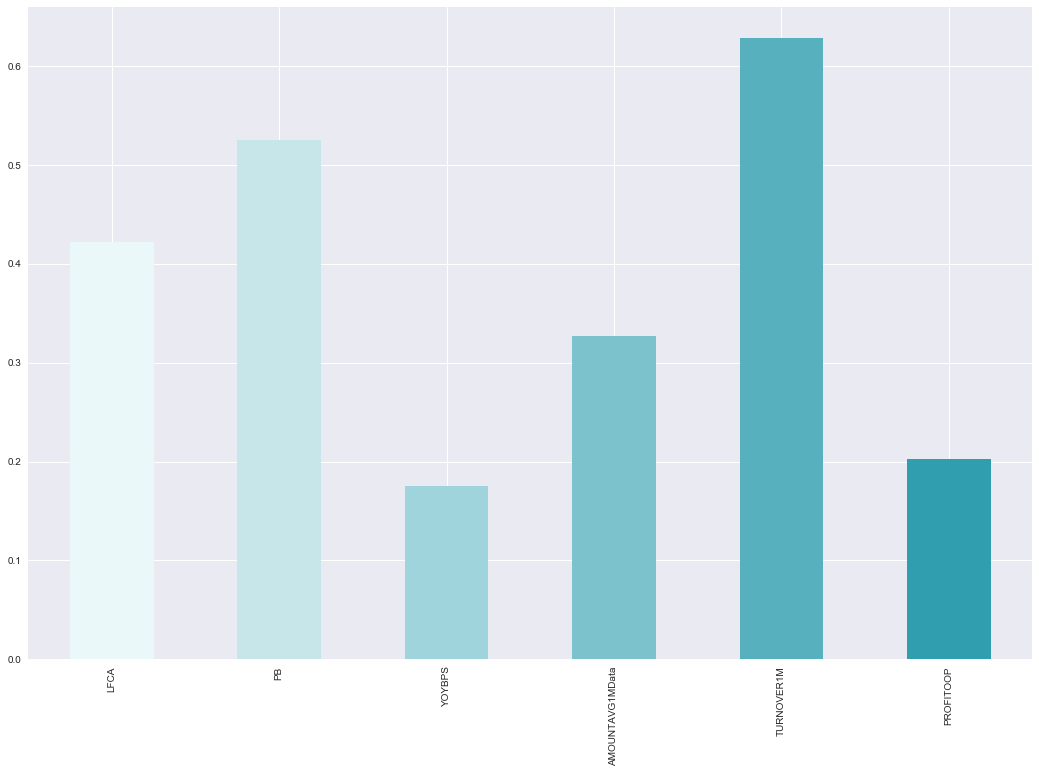

In [96]:
color_set=sns.light_palette((210, 90, 60), input="husl")
(factorPvalue[factorPvalue < 0.05].count()/len(factorPvalue)).plot(figsize=(18,12),kind='bar',color=sns.color_palette(color_set,10))

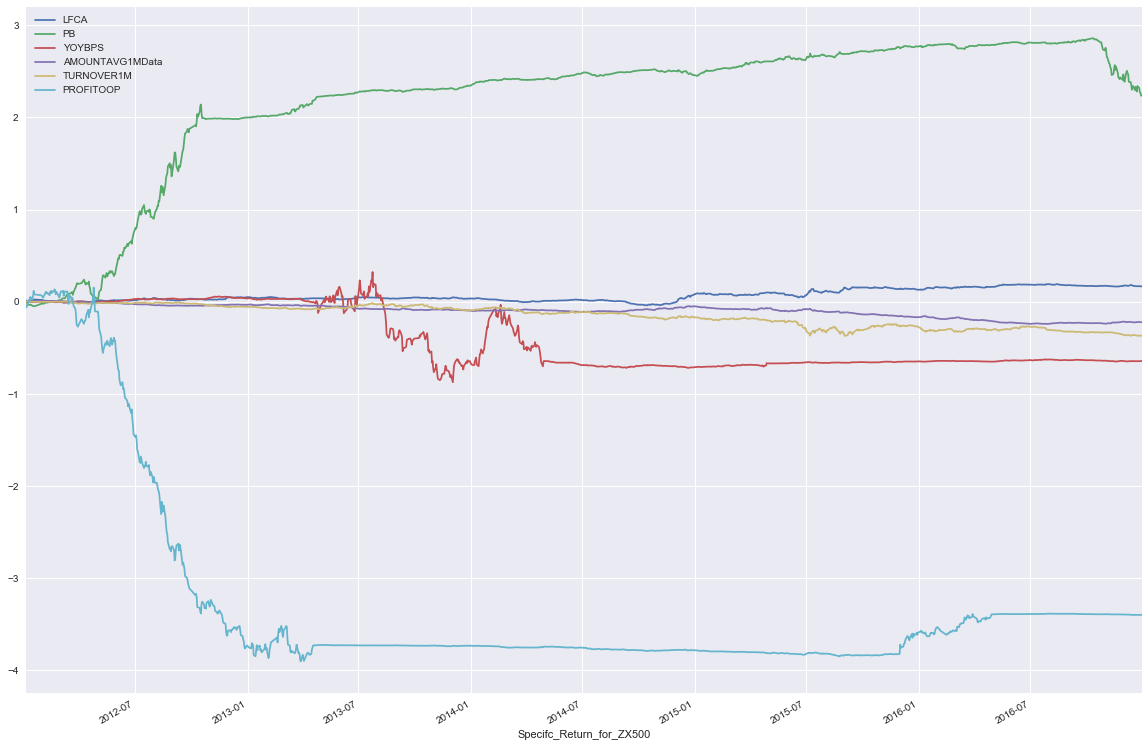

In [97]:
factorReturn.cumsum().plot(figsize=(20,14))

In [98]:
factorReturn.describe()

,LFCA,PB,YOYBPS,AMOUNTAVG1MData,TURNOVER1M,PROFITOOP
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,0.000138,0.001844,-0.000530,-0.000184,-0.000306,-0.002801
std,0.003104,0.018440,0.023450,0.001884,0.004886,0.026907
min,-0.018767,-0.125413,-0.164897,-0.008586,-0.025073,-0.214041
25%,-0.001447,-0.001921,-0.001335,-0.001211,-0.002268,-0.001897
50%,-0.000213,0.000765,-0.000054,-0.000234,-0.000122,-0.000158
75%,0.001137,0.003673,0.001293,0.000902,0.001962,0.000922
max,0.023948,0.167759,0.166723,0.007942,0.022233,0.134320


In [99]:
result2 = sm.OLS(factorReturn['PB'],factorReturn['LFCA']).fit()

In [100]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PB   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6427
Date:                Wed, 26 Apr 2017   Prob (F-statistic):              0.423
Time:                        09:40:43   Log-Likelihood:                 3117.4
No. Observations:                1213   AIC:                            -6233.
Df Residuals:                    1212   BIC:                            -6228.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
LFCA          -0.1373      0.171     -0.802      0.423      -0.473       0.199
==============================================================================
Omnibus:                      527.561   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18261.231
Skew:                           1.346   Prob(JB):                         0.00
Kurtosis:                      21.817   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
specificReturn

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
Specifc_Return_for_ZX500,,,,,,,,,,,,,,,,,,,,,
2012-01-05,0.025697,-0.003473,0.037547,0.008942,-0.016753,-0.008696,-0.063853,-0.037908,0.003391,0.043417,...,-0.006358,0.025833,0.017932,0.015733,0.014046,0.047862,-0.010460,-0.016782,-0.034919,-0.028392
2012-01-06,0.009798,-0.002888,-0.014237,-0.001026,0.008056,0.008518,-0.076295,0.035727,0.012290,0.042268,...,0.007569,0.025506,0.007685,0.032604,0.004787,-0.002140,-0.026344,-0.000980,0.006110,0.020083
2012-01-09,-0.002461,-0.003984,-0.008911,0.008975,-0.001940,0.004855,-0.009167,0.023284,0.001697,-0.023664,...,0.002377,-0.014051,-0.012759,0.004765,-0.013659,-0.037539,0.002730,0.019514,0.008412,-0.039856
2012-01-10,-0.006802,-0.005576,-0.014091,-0.018444,-0.002437,-0.000084,0.061007,0.024528,-0.000246,-0.021472,...,-0.000985,0.005040,0.000618,-0.019920,-0.011203,-0.040650,0.030107,-0.000083,0.021606,0.021835
2012-01-11,0.045727,0.012534,-0.004737,-0.021131,-0.011484,0.000324,0.017528,-0.022103,-0.006171,-0.014216,...,-0.007070,0.005367,0.003865,-0.006986,0.004961,-0.005496,-0.012906,-0.007782,-0.008659,0.094105
2012-01-12,-0.009627,-0.009251,-0.003970,-0.016977,-0.002378,0.007949,-0.016876,0.007746,0.001761,-0.001463,...,0.000756,-0.014743,-0.005372,-0.002584,-0.018490,0.001313,-0.001444,-0.005423,0.036531,-0.017246
2012-01-13,-0.010242,0.020970,-0.002322,-0.040364,-0.000066,0.000146,0.017963,-0.008312,-0.005817,0.007578,...,-0.004806,-0.007751,0.008295,0.002108,-0.022852,0.039016,-0.015669,-0.015496,0.032646,-0.026736
2012-01-16,0.020199,-0.021679,0.007341,-0.001592,-0.010316,-0.006683,0.018280,-0.001341,0.008870,0.003953,...,0.005323,0.008468,0.018731,0.021012,-0.070429,0.035611,-0.011880,0.010993,-0.011707,-0.003663
2012-01-17,-0.054877,-0.000032,-0.011086,-0.017507,0.003734,-0.005409,0.000674,0.026957,0.001241,-0.006605,...,0.004167,0.006175,0.001760,0.006243,-0.022848,-0.051361,0.002953,-0.003269,0.002274,0.025790


In [102]:
result1 = sm.OLS(returnOfBench, factorReturn).fit()

In [103]:
result1 .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              000905.SH   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     336.2
Date:                Wed, 26 Apr 2017   Prob (F-statistic):          2.15e-253
Time:                        09:40:44   Log-Likelihood:                 3696.9
No. Observations:                1213   AIC:                            -7382.
Df Residuals:                    1207   BIC:                            -7351.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
LFCA               -0.8877      0.110     -8.092      0.000      -1.103      -0.672
PB                 -0.0405      0.022     -1.871      0.062      -0.083       0.002
YOYBPS             -0.0398      0.015     -2.708      0.007      -0.069      -0.011
AMOUNTAVG1MData     0.9825      0.191      5.140      0.000       0.607       1.357
TURNOVER1M          3.0035      0.074     40.779      0.000       2.859       3.148
PROFITOOP           0.0772      0.015      5.298      0.000       0.049       0.106
==============================================================================
Omnibus:                       77.445   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.322
Skew:                          -0.130   Prob(JB):                     3.04e-67
Kurtosis:                       5.448   Cond. No.                         17.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
result1.resid.head(10)

Specifc_Return_for_ZX500
2012-01-05   -0.030171
2012-01-06   -0.001059
2012-01-09    0.032445
2012-01-10    0.041967
2012-01-11    0.000153
2012-01-12   -0.000846
2012-01-13   -0.028417
2012-01-16   -0.024800
2012-01-17    0.050525
2012-01-18   -0.021567
dtype: float64

In [105]:
1.247**5

3.0153120786310086

In [106]:
print PBData.shape,YOYBPSData.shape,AMOUNTAVG1MData .shape, TURNOVER1MData.shape,PROFITOOPData.shape

(1214, 1071) (1214, 1071) (1214, 1071) (1214, 1071) (1214, 1071)


In [107]:
PriceDF

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
LZ_GPA_DERI_AdjustedPriceForward_20-d,,,,,,,,,,,,,,,,,,,,,
2012-01-04,2.95251,10.25091,5.49539,5.93078,9.33043,7.62428,13.27401,8.09095,3.81523,2.97514,...,19.48821,4.54020,2.65200,12.10778,14.57299,4.87935,5.69,13.19030,5.08136,3.17793
2012-01-05,2.92215,9.79264,5.53478,5.73013,8.86761,7.20070,11.94563,7.51623,3.66887,2.97514,...,18.98636,4.47361,2.60325,12.03819,14.45932,4.87935,5.40,12.52060,4.66601,2.93332
2012-01-06,2.96010,9.79264,5.48554,5.73899,8.98794,7.28936,11.11907,7.85747,3.72742,3.11126,...,19.19927,4.60679,2.63250,12.51535,14.55935,4.87935,5.28,12.55942,4.73645,3.00377
2012-01-09,3.07395,10.12067,5.65296,6.01635,9.33043,7.63413,11.47331,8.36933,3.89329,3.16959,...,19.98244,4.73997,2.71050,13.07203,14.68666,4.87935,5.52,13.31648,4.98663,3.00377
2012-01-10,3.18021,10.47764,5.80068,6.15798,9.68217,7.95919,12.62458,8.90813,4.05917,3.23765,...,20.75802,4.96395,2.82750,13.32055,15.00040,4.87935,5.92,13.86001,5.26596,3.19358
2012-01-11,3.32442,10.65130,5.77114,6.04880,9.57110,7.98874,12.86074,8.71955,4.03966,3.19876,...,20.51470,4.99422,2.83725,13.18138,15.13681,4.87935,5.85,13.74354,5.21738,3.51255
2012-01-12,3.28647,10.55965,5.74159,5.94553,9.53407,8.03800,12.61474,8.77343,4.03966,3.18904,...,20.52991,4.90947,2.81775,13.12173,14.91856,4.87935,5.83,13.64648,5.34854,3.44993
2012-01-13,3.14226,10.41010,5.55448,5.47343,9.22861,7.69323,12.40810,8.39627,3.85426,3.08209,...,19.99765,4.67944,2.73975,12.83345,14.43658,4.87935,5.51,12.98648,5.31940,3.21511
2012-01-16,3.11190,9.84088,5.43630,5.28459,8.85836,7.37801,12.23098,8.12687,3.76645,2.99458,...,19.62507,4.57047,2.71050,12.78375,13.00429,4.87935,5.27,12.74383,5.04250,3.08596


In [108]:
def f(series, i, l):                                   
    s = rc.iloc[(i*l):((i+1)*l)]
    try:
        return s.loc[[s.idxmax()]]
    except:
        return None

In [109]:
len(PriceDF.iloc[:,0])

1214

In [110]:
%timeit a = pd.concat([f(PriceDF.iloc[:,0], i, 20) for i in range(len(PriceDF.iloc[:,0]))])

NameError: global name 'rc' is not defined

In [1]:
from __future__ import print_function
import sys
print(sys.argv, len(sys.argv))

['c:\\python27\\lib\\site-packages\\ipykernel\\__main__.py', '-f', 'C:\\Users\\LZJF_02\\AppData\\Roaming\\jupyter\\runtime\\kernel-edbf3667-ffdf-4939-b13f-716e7e28e5bb.json'] 3


In [3]:
import requests
from bs4 import BeautifulSoup

In [69]:
url = 'http://gs.amac.org.cn/amac-infodisc/res/pof/manager/managerList.html'
r = requests.get(url)
r.headers['content-type']

'text/html'

In [81]:
url = 'http://gs.amac.org.cn/amac-infodisc/res/pof/manager/managerList.html'
r = requests.get(url)
r.encoding = 'utf-8'
html_doc = BeautifulSoup(r.text,"html")

In [82]:
html_doc

<!DOCTYPE html>\n<html><head lang="en">\n    <meta charset="unicode-escape"/>\n    <title>\u79c1\u52df\u57fa\u91d1\u7ba1\u7406\u4eba\u5206\u7c7b\u516c\u793a - \u4e2d\u56fd\u57fa\u91d1\u4e1a\u534f\u4f1a</title>\n    <link href="../../common/css/reset.css" rel="stylesheet" type="text/css"/>\n    <link href="../../common/css/unit.css" rel="stylesheet" type="text/css"/>\n    <link href="../../common/css/grid.css" rel="stylesheet" type="text/css"/>\n    <link href="../../common/css/global.css" rel="stylesheet" type="text/css"/>\n    <link href="../../common/css/module.css" rel="stylesheet" type="text/css"/>\n    <link href="../../lib/dataTable/css/jquery.dataTables.css" rel="stylesheet" type="text/css"/>\n    <style type="text/css">\n        .w100 {\n            width: 100px;\n        }\n\n        .controls ul li {\n            cursor: pointer;\n            line-height: 180%;\n        }\n\n        .controls ul li:hover {\n            background: #eee;\n        }\n\n        #controls div {\n

In [26]:
# coding=utf-8
import urllib
import urllib2
import json

#url地址
url='https://www.baidu.com/s'
#参数
values={
        'ie':'UTF-8',
        'wd':'test'  
        }
#进行参数封装
data=urllib.urlencode(values)
#组装完整url
req=urllib2.Request(url,data)

#访问完整url
response = urllib2.urlopen(req)
html = response.read()

print (html)

<!DOCTYPE html>
<!--STATUS OK-->
<html>
<head>
    <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">
    <meta http-equiv="content-type" content="text/html;charset=utf-8">
    <meta content="always" name="referrer">
    <title>页面不存在_百度搜索</title>
    <style data-for="result">
        body {color: #333; background: #fff; padding: 0; margin: 0; position: relative; min-width: 700px; font-family: arial; font-size: 12px }
        p, form, ol, ul, li, dl, dt, dd, h3 {margin: 0; padding: 0; list-style: none }
        input {padding-top: 0; padding-bottom: 0; -moz-box-sizing: border-box; -webkit-box-sizing: border-box; box-sizing: border-box } img {border: none; }
        .logo {width: 117px; height: 38px; cursor: pointer }
         #wrapper {_zoom: 1 }
        #head {padding-left: 35px; margin-bottom: 20px; width: 900px }
        .fm {clear: both; position: relative; z-index: 297 }
        .btn, #more {font-size: 14px } 
        .s_btn {width: 95px; height: 32px; padding-top: 2px\

In [31]:
json.loads(response.read())

ValueError: No JSON object could be decoded

In [127]:
import requests
from bs4 import BeautifulSoup
import json
import re

# 确定测试爬虫页面
#page_index = input('Pls input the page_index you want to try:')
surl = 'http://gs.amac.org.cn/amac-infodisc/res/pof/manager/101000000138.html'

# 使用requests获取网页
r = requests.get( surl)
#content = re.sub(r'(?m)^\<!--.*\n?', '', r.content)
#content = re.sub(r'(?m)^\-->.*\n?', '', content)
soup = BeautifulSoup(r.content, 'html.parser')
#print len(soup.find_all('table'))
for table in soup.find_all('table'):
    if table.findParent("table") is None:
        print "\n\n", str(table)

# 使用BS提取内容
#soup = BeautifulSoup(req.content,'lxml')

# 使用json将其转换为dict
#res_json = json.loads(res)
#json.dumps(res_json, indent = 4)



<table class="table table-center table-info">
<colgroup>
<col width="25%"/>
<col width="25%"/>
<col width="25%"/>
<col width="25%"/>
</colgroup>
<tbody>
<tr>
<td class="td-title">机构诚信信息:</td>
<td class="td-content" colspan="3">
<table class="table table-center table-info">
</table>
</td>
</tr>
<tr>
<td colspan="4" style="padding: 0px 0px;text-align: left;">
<div style="background-color: #DFDFDF;padding: 8px 10px;font-weight:bold;">机构信息</div>
</td>
</tr>
<tr>
<td class="td-title">基金管理人全称(中文):</td>
<td class="td-content" colspan="2">
<div id="complaint1" style="display: none;">平安道远投资管理（上海）有限公司  </div>
<div id="complaint2">平安道远投资管理（上海）有限公司   <input id="complaint" onclick="complain();" style="border:none;background-color:#b64545;color:#FFF;width:50px;border-radius:4px;" type="button" value="投诉"/>
</div>
</td>
<td class="td-code" rowspan="3">
<div id="qrcode"></div>
</td>
</tr>
<tr>
<td class="td-title">基金管理人全称(英文):</td>
<td class="td-content" colspan="2">Ping An DaoYuan Investment Manage

In [167]:
soup.find_all('a')

[<a class="logo pull-left" href="/">\n<img alt="\u4e2d\u56fd\u57fa\u91d1\u4e1a\u534f\u4f1a\u4fe1\u606f\u516c\u793a" class="img-desktop" src="../../common/images/logo.png"/>\n<img alt="\u4e2d\u56fd\u57fa\u91d1\u4e1a\u534f\u4f1a\u4fe1\u606f\u516c\u793a" class="img-responsive" src="../../common/images/logo_mobile.png"/>\n</a>,
 <a class="text-danger ml15" href="#" id="comfirmMsg" onclick="openAMACInfo();">&lt;\r\n                    &lt;\u4e2d\u56fd\u8bc1\u5238\u6295\u8d44\u57fa\u91d1\u4e1a\u534f\u4f1a\u63d0\u793a&gt;&gt;\r\n                </a>,
 <a class="a1" href="mailto:pf@amac.org.cn" style="color: #173bf4;">pf@amac.org.cn</a>,
 <a class="a1" href="mailto:pf@amac.org.cn" style="color: #173bf4;">pf@amac.org.cn</a>,
 <a href="javascript:void(0);" onclick="javascript:gotoWebsite('http://russell.pingan.com/index.shtml');">http://russell.pingan.com/index.shtml</a>,
 <a href="../fund/351000131340.html">\u5e73\u5b89\u8d44\u4ea7MOM1\u53f7\u8d44\u4ea7\u7ba1\u7406\u4ea7\u54c1</a>,
 <a href="..

In [174]:
soup.find_all('a', class_=re.compile(ur'bgwhite\st-[\u4e00-\u9fff]+'))

[]

In [228]:
 u'量化'

u'\u91cf\u5316'

In [193]:
u'对冲'.decode('gb2312')

UnicodeEncodeError: 'ascii' codec can't encode characters in position 0-1: ordinal not in range(128)

In [277]:
import requests
from bs4 import BeautifulSoup

suffix = '101000000138.html'
target = [u'量化',u'对冲']

def is_true_quant(suffix):
    Flag = False
    surl = 'http://gs.amac.org.cn/amac-infodisc/res/pof/manager/' + suffix

    # 使用requests获取网页
    r = requests.get( surl)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    for item in soup.find_all('a', href=True):
        if item['href'].endswith('html'):
            base = soup('a',{'href':item['href']})[0].contents[0] # 返回 href后面对应的文字
            print base  
            if  target[0] in base or target[1] in base:
                Flag = True
                break
    return Flag

In [278]:
is_true_quant(suffix)

平安资产MOM1号资产管理产品
罗素投资合格投资者中国基金
平安人寿绝对收益账户
交银国信 平安罗素MOM一期多元投资集合资金信托计划
平安资产MOM2号保险资产管理产品
平安资产MOM3号保险资产管理产品
平安道远STAR21号私募基金 
平安道远STAR27号私募基金 
平安道远STAR19号私募基金 
平安道远STAR2号私募基金 
平安道远STAR28号私募基金 
平安道远STAR3号私募基金 
平安道远STAR20号私募基金 
平安道远STAR4号私募基金 
平安道远STAR10号私募基金 
平安道远STAR29号私募基金 
平安道远投资管理（上海）有限公司稳盈1号私募投资基金 
平安养老-平安罗素道远1号资产管理产品 
平安道远STAR17号私募基金 
平安道远STAR8号私募基金 
平安道远STAR26号私募基金 
平安道远STAR18号私募基金 
平安道远STAR1号私募基金 
平安道远STAR15号私募基金 
平安道远金锁2号基金 
平安道远STAR16号私募基金 
平安道远STAR25号私募基金 
平安道远STAR5号私募基金 
民生通惠优选1号保险资产管理产品 
平安道远STAR30号私募基金 
平安道远投资管理（上海）有限公司安享1号私募投资基金 
平安道远STAR6号私募基金 
平安道远STAR7号私募基金 
平安道远投资管理（上海）有限公司稳盈2号私募投资基金 
平安道远STAR11号私募基金 
平安道远金锁1号资产管理计划 
平安道远STAR12号私募基金 
平安道远STAR22号私募基金 


False

In [281]:
#soup('a',{'href':})[0].contents[0] 

In [282]:
fund_path = 'C:/Users/LZJF_02/Desktop/myjob/web_crawling/fundlist'
filename0 = 'zizhu1-10.csv'
filename1 = 'guwen1-10.csv'

In [337]:
data1 = pd.read_csv(fund_path+'/'+filename0,encoding ='gbk')

In [341]:
data1['type'] = u'自主'
data1['size']

In [342]:
data1.fundScale

0       9.309265e+05
1       3.418153e+05
2       7.501422e+04
3       6.705248e+05
4       9.839621e+05
5       5.485847e+05
6       8.902925e+04
7       1.089406e+05
8       3.135787e+05
9       2.021778e+04
10      1.600695e+05
11      1.244000e+04
12      4.315295e+04
13      7.704000e+05
14      9.407056e+04
15      1.247753e+06
16      9.224500e+04
17      1.619245e+05
18      9.789640e+04
19      1.650072e+04
20      3.279377e+05
21      1.111600e+05
22      3.677000e+04
23      9.428028e+04
24      8.609573e+04
25      5.747272e+05
26      3.516764e+04
27      4.683099e+04
28      1.246248e+05
29      1.156022e+05
            ...     
1190    1.996811e+04
1191    5.888500e+04
1192    1.471550e+04
1193    2.870986e+05
1194    1.325998e+04
1195    2.740000e+04
1196    3.820738e+04
1197    3.401300e+04
1198    3.020000e+04
1199    2.000050e+04
1200    1.719913e+04
1201    1.100000e+04
1202    7.480869e+04
1203    1.836200e+04
1204    1.200027e+04
1205    1.153000e+04
1206    1.905

930926.5

In [331]:
city = u'上海'

In [332]:
data1['city'] =  data1['managerName'].apply(lambda x : 1 if city in x else 0 )

In [333]:
data1[(data1['city'] ==1) & (data1[u'含量化或对冲'] ==True )]

,id,managerName,fundScale,含量化或对冲,city,type
0,101000000172,富舜资产管理（上海）有限公司,9.309265e+05,True,1,自主
2,101000000578,上海尚雅投资管理有限公司,7.501422e+04,True,1,自主
5,101000000196,上海国富投资管理有限公司,5.485847e+05,True,1,自主
6,101000000458,上海万丰友方投资管理有限公司,8.902925e+04,True,1,自主
14,101000000374,上海涌峰投资管理有限公司,9.407056e+04,True,1,自主
31,101000001316,浙商控股集团上海资产管理有限公司,2.754900e+04,True,1,自主
34,101000000694,上海游马地投资中心（有限合伙）,4.192697e+04,True,1,自主
39,101000001661,上海鼎锋资产管理有限公司,1.778855e+05,True,1,自主
44,101000000491,上海理石投资管理有限公司,2.301286e+05,True,1,自主
45,101000001221,上海恒如投资管理有限公司,6.176445e+04,True,1,自主


In [ ]:
data